Data OK — sample: c[1]=760.0  D[1,1]=266.0  W[1,1]=93.1  p[1,1]=837.0  MCap[1]=140.0
Iter 00 | cuts: 0 | master: BOOTSTRAP x=0, alpha=0
  LB=0.000  UB=30,066,588.289  gap=3.007e+07  sum(x)=0.000  avg x=0.000
Iter 01 | cuts: 1 | master status: optimal
  LB=1,872,049.680  UB=25,520,041.623  gap=2.365e+07  sum(x)=2451.888  avg x=102.162
Iter 02 | cuts: 2 | master status: optimal
  LB=1,878,332.300  UB=23,312,477.271  gap=2.143e+07  sum(x)=2451.888  avg x=102.162
Iter 03 | cuts: 3 | master status: optimal
  LB=1,878,332.300  UB=19,690,862.635  gap=1.781e+07  sum(x)=2451.888  avg x=102.162
Iter 04 | cuts: 4 | master status: optimal
  LB=1,881,931.118  UB=17,032,965.037  gap=1.515e+07  sum(x)=2451.888  avg x=102.162
Iter 05 | cuts: 5 | master status: optimal
  LB=1,882,663.701  UB=14,350,219.406  gap=1.247e+07  sum(x)=2451.888  avg x=102.162
Iter 06 | cuts: 6 | master status: optimal
  LB=1,888,273.668  UB=14,971,971.308  gap=1.308e+07  sum(x)=2451.888  avg x=102.162
Iter 07 | cuts: 7 | mast

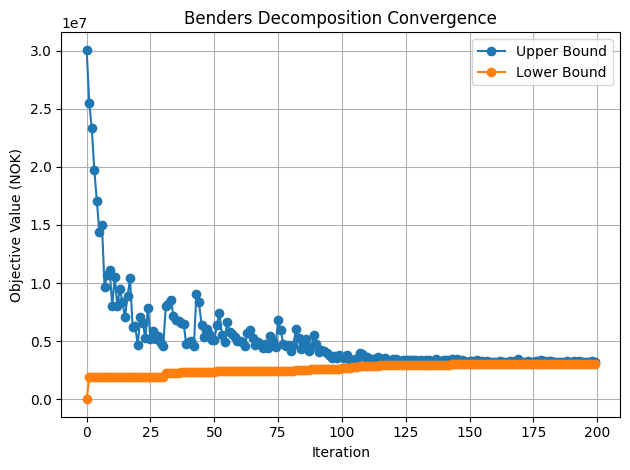

In [1]:
# ===========================
# Two-Stage Stochastic Energy Scheduling (Benders)
# x_t is CONTINUOUS (NonNegativeReals) + 30% minimum day-ahead commitment
# ===========================

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo

# --------- User paths ---------
DATA_DIR = Path(r"C:\MOD500\Optimization\Optimization.Assignment")
SAVE_CSV = False   # set True if you want CSV outputs

# --------- Sets & probabilities ---------
T = list(range(1, 25))         # hours 1..24
S = [1, 2, 3]                  # scenarios
p = {1: 0.3, 2: 0.4, 3: 0.3}   # scenario probabilities

# --------- Robust loaders ----------
def load_ct(path: Path):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Hour(t)":"hour","Hour (t)":"hour","Hour":"hour","hour":"hour",
        "Cost c_{t} (NOK/MWh)":"c","Cost c_t (NOK/MWh)":"c","Cost":"c"
    })
    if "hour" not in df.columns: df = df.rename(columns={df.columns[0]:"hour"})
    if "c"    not in df.columns: df = df.rename(columns={df.columns[1]:"c"})
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["c"]    = pd.to_numeric(df["c"],    errors="coerce")
    df = df.dropna(subset=["hour"]).set_index("hour")
    df = df[~df.index.duplicated(keep="first")]
    return {int(t): float(df.at[t, "c"]) for t in T}

def load_3scen(path: Path):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Hour(t)":"hour","Hour (t)":"hour","Hour":"hour","hour":"hour",
        "Low demand s = 1":"s1","Medium demand s = 2":"s2","High demand s = 3":"s3",
        "Low demand s=1":"s1","Medium demand s=2":"s2","High demand s=3":"s3",
    })
    if "hour" not in df.columns: df = df.rename(columns={df.columns[0]:"hour"})
    for k in (1,2,3):
        col = f"s{k}"
        if col not in df.columns:
            cands = [c for c in df.columns if c != "hour" and str(k) in c]
            if cands: df = df.rename(columns={cands[0]: col})
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    for k in (1,2,3):
        df[f"s{k}"] = pd.to_numeric(df.get(f"s{k}"), errors="coerce")
    df = df.dropna(subset=["hour"])
    df["hour"] = df["hour"].astype(int)
    df = df.set_index("hour")
    df = df[~df.index.duplicated(keep="first")]
    return {(k, t): float(df.at[t, f"s{k}"]) for k in S for t in T}

def load_MCap(path: Path):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Hour(t)":"hour","Hour (t)":"hour","Hour":"hour","hour":"hour",
        "Mcap,t (MWh)":"MCap","Mcap (MWh)":"MCap","Mcap":"MCap"
    })
    if "hour" not in df.columns: df = df.rename(columns={df.columns[0]:"hour"})
    if "MCap" not in df.columns: df = df.rename(columns={df.columns[1]:"MCap"})
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["MCap"] = pd.to_numeric(df["MCap"], errors="coerce")
    df = df.dropna(subset=["hour"]).set_index("hour")
    df = df[~df.index.duplicated(keep="first")]
    return {int(t): float(df.at[t, "MCap"]) for t in T}

# --------- Read data ----------
c      = load_ct   (DATA_DIR / "table1_ct.csv")
D      = load_3scen(DATA_DIR / "table2_D.csv")
W      = load_3scen(DATA_DIR / "table3_W.csv")
pprice = load_3scen(DATA_DIR / "table4_p.csv")      # cleaned price table from earlier step
MCap   = load_MCap (DATA_DIR / "table5_MCap.csv")

# Xmax bounds (per assignment-friendly choice)
Xmax = {t: max(D[(s, t)] for s in S) for t in T}

# --------- Constants ----------
kpen = {(s,t): 320.0 for s in S for t in T}  # wind curtailment
Emax, Pchg, Pdis = 120.0, 45.0, 55.0
eta_chg, eta_dis = 0.95, 0.95
S0, Smin, Smax   = 60.0, 55.0, 85.0
beta, Punmet     = 12.0, 100000.0
commit_frac      = 0.30     # 30% min day-ahead purchase (aggregated)

# --------- Master model (x continuous) ----------
def build_master(Cuts):
    m = pyo.ConcreteModel()
    # x_t in R_+, bounded by Xmax[t]
    def x_bounds(_m, t): return (0, Xmax[t])
    m.x     = pyo.Var(T, within=pyo.NonNegativeReals, bounds=x_bounds)
    m.alpha = pyo.Var(bounds=(0.0, 1e12))

    # store cuts
    m.Cut     = pyo.Set(initialize=Cuts["Set"])
    m.Phi     = pyo.Param(m.Cut, initialize=Cuts["Phi"], mutable=True, default=0.0)
    m.Lambda  = pyo.Param(T, m.Cut,
                          initialize=lambda m, t, cidx: Cuts["Lambda"].get((t, cidx), 0.0),
                          mutable=True, default=0.0)
    m.x_fixed = pyo.Param(T, m.Cut,
                          initialize=lambda m, t, cidx: Cuts["x_fixed"].get((t, cidx), 0.0),
                          mutable=True, default=0.0)

    # objective
    m.obj = pyo.Objective(expr=sum(c[t] * m.x[t] for t in T) + m.alpha, sense=pyo.minimize)

    # Benders cuts
    def cut_rule(m, cidx):
        return m.alpha >= m.Phi[cidx] + sum(m.Lambda[t, cidx] * (m.x[t] - m.x_fixed[t, cidx]) for t in T)
    m.Benders = pyo.Constraint(m.Cut, rule=cut_rule)

    # --- 30% minimum day-ahead commitment (aggregated) ---
    E_total = sum(p[s] * D[(s, t)] for s in S for t in T)
    m.min_commit = pyo.Constraint(expr=sum(m.x[t] for t in T) >= commit_frac * E_total)

    return m

# --------- Subproblem (scenario s) ----------
def build_subproblem(x_fixed, s):
    sp = pyo.ConcreteModel()
    sp.T = pyo.Set(initialize=T)

    sp.mkt = pyo.Var(sp.T, within=pyo.NonNegativeReals)  # market purchase
    sp.q   = pyo.Var(sp.T, within=pyo.NonNegativeReals)  # charge
    sp.r   = pyo.Var(sp.T, within=pyo.NonNegativeReals)  # discharge
    sp.u   = pyo.Var(sp.T, within=pyo.NonNegativeReals)  # curtailment
    sp.l   = pyo.Var(sp.T, within=pyo.NonNegativeReals)  # unmet
    sp.S   = pyo.Var(sp.T)                               # state of charge

    sp.obj = pyo.Objective(
        expr=p[s] * sum(
            pprice[(s, t)] * sp.mkt[t] +
            kpen[(s, t)]   * sp.u[t]   +
            Punmet         * sp.l[t]   +
            beta * (sp.q[t] + sp.r[t])
            for t in sp.T
        ),
        sense=pyo.minimize
    )

    # capacities
    sp.mcap = pyo.Constraint(sp.T, rule=lambda m, t: m.mkt[t] <= MCap[t])
    sp.qcap = pyo.Constraint(sp.T, rule=lambda m, t: m.q[t]   <= Pchg)
    sp.rcap = pyo.Constraint(sp.T, rule=lambda m, t: m.r[t]   <= Pdis)

    # battery SoC box + dynamics
    sp.Slo  = pyo.Constraint(sp.T, rule=lambda m, t: Smin <= m.S[t])
    sp.Shi  = pyo.Constraint(sp.T, rule=lambda m, t: m.S[t] <= Emax)
    def soc(m, t):
        if t == 1:
            return m.S[t] == S0 + eta_chg * m.q[t] - eta_dis * m.r[t]
        return m.S[t] == m.S[t-1] + eta_chg * m.q[t] - eta_dis * m.r[t]
    sp.soc = pyo.Constraint(sp.T, rule=soc)
    sp.Send_lo = pyo.Constraint(expr=sp.S[max(T)] >= Smin)
    sp.Send_hi = pyo.Constraint(expr=sp.S[max(T)] <= Smax)

    # power balance (RHS = D - x_t ⇒ gradient wrt x is -lambda)
    sp.balance = pyo.Constraint(
        sp.T,
        rule=lambda m, t: m.r[t] + m.mkt[t] + (W[(s, t)] - m.u[t]) + m.l[t] - m.q[t] == D[(s, t)] - x_fixed[t]
    )

    sp.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    return sp

# --------- Cut aggregation ----------
def add_cut(Cuts, Sub, x_fixed):
    cidx = len(Cuts["Set"])
    Cuts["Set"].append(cidx)
    Phi_total = sum(pyo.value(Sub[s].obj) for s in S)  # already probability-weighted
    Cuts["Phi"][cidx] = Phi_total
    for t in T:
        lam_sum = sum(Sub[s].dual[Sub[s].balance[t]] for s in S)  # free duals on equality
        Cuts["Lambda"][(t, cidx)] = -lam_sum                      # IMPORTANT sign
        Cuts["x_fixed"][(t, cidx)] = x_fixed[t]
    return Cuts

# --------- Save (optional) ----------
def save_results(x_fixed, Sub, UB_hist, LB_hist):
    if SAVE_CSV:
        pd.DataFrame({"hour": T, "x_t": [float(x_fixed[t]) for t in T]}).to_csv("x_day_ahead.csv", index=False)
        rows = []
        for s in S:
            m = Sub[s]
            for t in T:
                rows.append({"scenario": s, "hour": t,
                             "mkt": pyo.value(m.mkt[t]), "q": pyo.value(m.q[t]), "r": pyo.value(m.r[t]),
                             "u": pyo.value(m.u[t]), "l": pyo.value(m.l[t]), "S": pyo.value(m.S[t])})
        pd.DataFrame(rows).to_csv("subproblem_results.csv", index=False)
    # plot
    it = list(range(len(UB_hist)))
    plt.figure()
    plt.plot(it, UB_hist, marker='o', label='Upper Bound')
    plt.plot(it, LB_hist, marker='o', label='Lower Bound')
    plt.xlabel('Iteration'); plt.ylabel('Objective Value (NOK)')
    plt.title('Benders Decomposition Convergence'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig("convergence.png")

# --------- Main Benders loop (bootstrap + LP fallback) ----------
def benders_main():
    solver = pyo.SolverFactory("glpk")
    Cuts = {"Set": [], "Phi": {}, "Lambda": {}, "x_fixed": {}}
    tol, max_iters = 1e-4, 200
    UB_hist, LB_hist = [], []
    prev_x = {t: 0.0 for t in T}

    for k in range(max_iters):
        # MASTER
        if len(Cuts["Set"]) == 0:
            x_fixed   = {t: 0.0 for t in T}
            alpha_val = 0.0
            LB        = 0.0
            print(f"Iter {k:02d} | cuts: 0 | master: BOOTSTRAP x=0, alpha=0")
        else:
            master = build_master(Cuts)
            resM   = solver.solve(master, load_solutions=True)
            print(f"Iter {k:02d} | cuts: {len(Cuts['Set'])} | master status: {resM.solver.termination_condition}")
            x_try     = {t: master.x[t].value for t in T}
            alpha_try = master.alpha.value

            # if any None → retry as LP (shouldn't happen with continuous x, but robust anyway)
            if any(v is None for v in x_try.values()):
                print("  No master values → retrying...")
                masterLP = build_master(Cuts)
                resLP = solver.solve(masterLP, load_solutions=True)
                x_try     = {t: masterLP.x[t].value for t in T}
                alpha_try = masterLP.alpha.value

            # final safety fallback
            if any(v is None for v in x_try.values()):
                x_try, alpha_try = prev_x.copy(), 0.0

            x_fixed   = {t: float(x_try[t]) for t in T}
            prev_x    = x_fixed.copy()
            alpha_val = float(alpha_try) if alpha_try is not None else 0.0
            LB        = sum(c[t] * x_fixed[t] for t in T) + alpha_val

        # SUBPROBLEMS
        Sub, q_vals = {}, {}
        for s in S:
            sp = build_subproblem(x_fixed, s)
            solver.solve(sp, load_solutions=True)
            q_vals[s] = pyo.value(sp.obj)
            Sub[s]    = sp

        inv_cost = sum(c[t] * x_fixed[t] for t in T)
        UB = inv_cost + sum(q_vals.values())
        UB_hist.append(UB); LB_hist.append(LB)
        print(f"  LB={LB:,.3f}  UB={UB:,.3f}  gap={UB-LB:,.3e}  "
              f"sum(x)={sum(x_fixed.values()):.3f}  avg x={sum(x_fixed.values())/24:.3f}")

        # convergence
        if (UB - LB) <= tol and len(Cuts["Set"]) > 0:
            print("\nConverged.")
            print("Day-ahead x_t (MWh, real values):")
            for t in T:
                print(f"  t={t:2d}  x={x_fixed[t]:.3f}")
            save_results(x_fixed, Sub, UB_hist, LB_hist)
            return

        # add one aggregated cut
        Cuts = add_cut(Cuts, Sub, x_fixed)

    # if not converged within max_iters
    print("\nMax iterations reached.")
    print("Day-ahead x_t (MWh, real values):")
    for t in T:
        print(f"  t={t:2d}  x={x_fixed[t]:.3f}")
    save_results(x_fixed, Sub, UB_hist, LB_hist)

# --------- Run ----------
if __name__ == "__main__":
    print(f"Data OK — sample: c[1]={c[1]}  D[1,1]={D[(1,1)]}  W[1,1]={W[(1,1)]}  "
          f"p[1,1]={pprice[(1,1)]}  MCap[1]={MCap[1]}")
    benders_main()
